## 🚀 Modificaciones aplicadas

1. **Teacher Forcing Ratio**  
   - Se añadió el parámetro `teacher_forcing_ratio` a la función `train` para alternar entre token real y predicho, reduciendo el _exposure bias_.  
2. **LSTM Bidireccional en Encoder**  
   - El `nn.LSTM` del encoder ahora usa `bidirectional=True` y concatena estados forward/backward.  
3. **Gradient Clipping y Scheduler**  
   - Se incorpora `torch.nn.utils.clip_grad_norm_` tras el _backward_ y un ejemplo de uso de `ReduceLROnPlateau`.  
4. **Métrica BLEU y Ejemplos de Inferencia**  
   - Añadido cálculo de BLEU tras cada epoch de validación y generación de ejemplos.  
5. **TorchText para Batching**  
   - Ejemplo de configuración de `Field` y `BucketIterator` para manejo automático de padding y longitudes.  


In [1]:
# # --- Mod: Entrenamiento con Teacher Forcing y Gradient Clipping ---
# import random
# from torch.nn.utils import clip_grad_norm_

# def train(model, iterator, optimizer, criterion, clip=1.0, teacher_forcing_ratio=0.5):
#     model.train()
#     epoch_loss = 0

#     for i, batch in enumerate(iterator):
#         src = batch.src      # [src_len, batch_size]
#         trg = batch.trg      # [trg_len, batch_size]
#         optimizer.zero_grad()

#         # Forward pass con teacher forcing ratio
#         output = model(src, trg, teacher_forcing_ratio)
#         # output: [trg_len, batch_size, output_dim]
#         output_dim = output.shape[-1]
#         output = output[1:].view(-1, output_dim)   # excluir <sos>
#         trg = trg[1:].view(-1)

#         loss = criterion(output, trg)
#         loss.backward()

#         # Aplicar gradient clipping
#         clip_grad_norm_(model.parameters(), clip)

#         optimizer.step()
#         epoch_loss += loss.item()

#     return epoch_loss / len(iterator)


In [2]:
# # --- Mod: Encoder Bidireccional ---
# import torch.nn as nn
# import torch

# class Encoder(nn.Module):
#     def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
#         super().__init__()
#         self.hid_dim = hid_dim
#         self.n_layers = n_layers

#         self.embedding = nn.Embedding(input_dim, emb_dim)
#         # Cambiado a bidireccional
#         self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers,
#                            dropout=dropout, bidirectional=True)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, src):
#         # src: [src_len, batch_size]
#         embedded = self.dropout(self.embedding(src))
#         # outputs: [src_len, batch_size, hid_dim*2]
#         outputs, (hidden, cell) = self.rnn(embedded)

#         # Concatenar hidden forward y backward
#         hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
#         cell   = torch.cat((cell[-2,:,:],   cell[-1,:,:]),   dim=1)

#         # Ajustar dimensiones para el decoder
#         return outputs, hidden.unsqueeze(0), cell.unsqueeze(0)


In [3]:
# # --- Mod: Ejemplo de configuración con TorchText ---
# from torchtext.legacy.data import Field, BucketIterator, TabularDataset

# # Definición de campos con SOS/EOS y manejo de longitudes
# SRC = Field(tokenize=lambda x: x.split(), 
#             init_token='<sos>', eos_token='<eos>', 
#             lower=True, include_lengths=True)
# TRG = Field(tokenize=lambda x: x.split(),
#             init_token='<sos>', eos_token='<eos>', 
#             lower=True)

# # Cargar dataset desde CSV/TSV (adaptar rutas y formato)
# # train_data, valid_data = TabularDataset.splits(
# #     path='.', train='train.csv', validation='valid.csv',
# #     format='csv', fields=[('src', SRC), ('trg', TRG)]
# # )

# # Construir vocabularios limitados y mínimos
# SRC.build_vocab(train_data, max_size=20000, min_freq=2)
# TRG.build_vocab(train_data, max_size=30000, min_freq=2)

# # Generar iteradores con sorting y padding automático
# train_iter, valid_iter = BucketIterator.splits(
#     (train_data, valid_data),
#     batch_size=32,
#     sort_within_batch=True,
#     sort_key=lambda x: len(x.src),
#     device=device)


<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

### Datos
El objecto es utilizar datos disponibles de Anki de traducciones de texto en diferentes idiomas. Se construirá un modelo traductor seq2seq utilizando encoder-decoder.\
[LINK](https://www.manythings.org/anki/)

In [4]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random  

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# Métrica de accuracy con máscara de padding
def sequence_acc(logits, tgt_idx, pad_idx=0):
    """
    logits : [B, L, V]  salida del modelo
    tgt_idx: [B, L]     índices ground-truth
    """
    pred_idx = logits.argmax(dim=-1)
    mask     = tgt_idx.ne(pad_idx)            # True donde hay palabra
    correct  = (pred_idx.eq(tgt_idx) & mask).float()
    total = mask.sum()
    return correct.sum() / total if total > 0 else torch.tensor(0.0)

# Función de entrenamiento
def train(model,
          train_loader,
          valid_loader,
          optimizer,
          criterion,              
          epochs     = 50,
          patience   = 7,
          min_delta  = 1e-4,
          device     = "cuda",
          pad_idx    = 0,
          teacher_forcing_ratio = 0.5):
    model.to(device)
    best_val_loss = float("inf")
    wait          = 0
    best_state    = None
    history = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}

    for epoch in range(1, epochs + 1):
        # ----- TRAIN -----
        model.train()
        tot_loss, tot_acc = 0, 0
        for enc_in, dec_in, tgt_idx in train_loader:
            enc_in   = enc_in.to(device)
            dec_in   = dec_in.to(device)
            tgt_idx  = tgt_idx.to(device)
            optimizer.zero_grad()
            # logits = model(enc_in, dec_in)            # [B, L, V]
            logits = model(enc_in, dec_in, teacher_forcing_ratio)
            B, L, V = logits.shape
            loss = criterion(logits.view(-1, V), tgt_idx.view(-1))
            loss.backward()
            optimizer.step()
            tot_loss += loss.item()
            tot_acc  += sequence_acc(logits, tgt_idx, pad_idx).item()
        train_loss = tot_loss / len(train_loader)
        train_acc  = tot_acc  / len(train_loader)

        # ----- VALID -----
        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for enc_in, dec_in, tgt_idx in valid_loader:
                enc_in  = enc_in.to(device)
                dec_in  = dec_in.to(device)
                tgt_idx = tgt_idx.to(device)
                logits = model(enc_in, dec_in)
                B, L, V = logits.shape
                loss = criterion(logits.view(-1, V), tgt_idx.view(-1))
                val_loss += loss.item()
                val_acc  += sequence_acc(logits, tgt_idx, pad_idx).item()
        val_loss /= len(valid_loader)
        val_acc  /= len(valid_loader)
        history["loss"].append(train_loss)
        history["accuracy"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        print(f"Epoch {epoch:3d}: "
              f"Train L={train_loss:.4f} A={train_acc:.4f} | "
              f"Val L={val_loss:.4f} A={val_acc:.4f}")

        # ----- EARLY STOPPING -----
        if val_loss + min_delta < best_val_loss:
            best_val_loss = val_loss
            best_state    = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history, model

### 1 - Datos

In [6]:
# dataset_file
text_file = "./clase/spa-eng/spa.txt"
with open(text_file, encoding="utf8") as f:
    lines = f.read().split("\n")[:-1]

# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 0

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

if MAX_NUM_SENTENCES == 0:
    MAX_NUM_SENTENCES = len(lines)
for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))
print(input_sentences[0], output_sentences[0], output_sentences_inputs[0])

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 118964
A deal is a deal. Un trato es un trato. <eos> <sos> Un trato es un trato.


### 2 - Preprocesamiento

In [7]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 30000

In [8]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from clase.torch_helpers import Tokenizer
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 13524
Sentencia de entrada más larga: 47


In [9]:
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 26341
Sentencia de salida más larga: 50


Como era de esperarse, las sentencias en castellano son más largas que en inglés, y lo mismo sucede con su vocabulario.

A la hora de realiza padding es importante teneer en cuenta que en el encoder los ceros se agregan al comienoz y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [10]:
from clase.torch_helpers import pad_sequences
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

Cantidad de rows del dataset: 118964
encoder_input_sequences shape: (118964, 47)
decoder_input_sequences shape: (118964, 50)
decoder_output_sequences shape: (118964, 50)


Cargamos un dataset sin one_hot encoding para ocupar menos memoria

In [11]:
class Seq2SeqDataset(Dataset):
    """
    Devuelve tensores int64 con PAD=0.
    ─ encoder_inputs : [N, T_enc]
    ─ decoder_inputs : [N, T_dec]   (<sos> + frase)
    ─ decoder_outputs: [N, T_dec]   (frase + <eos>)
    """
    def __init__(self, enc_arr: np.ndarray,
                       dec_in_arr: np.ndarray,
                       dec_out_arr: np.ndarray):

        # Convertir a tensores int64
        self.encoder_inputs  = torch.from_numpy(enc_arr    .astype(np.int64))
        self.decoder_inputs  = torch.from_numpy(dec_in_arr .astype(np.int64))
        self.decoder_outputs = torch.from_numpy(dec_out_arr.astype(np.int64))

        assert len(self.encoder_inputs) == len(self.decoder_inputs) == len(self.decoder_outputs), \
            "Los tres arrays deben tener la misma longitud"

    def __getitem__(self, idx):
        return (self.encoder_inputs [idx],
                self.decoder_inputs [idx],
                self.decoder_outputs[idx])

    def __len__(self):
        return len(self.encoder_inputs)
    
# Construcción
data_set = Seq2SeqDataset(encoder_input_sequences,
                          decoder_input_sequences,
                          decoder_output_sequences)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("decoder_input_size:", decoder_input_size)

output_dim = data_set.decoder_outputs.shape[1]
print("Output dim", output_dim)

encoder_input_size: 47
decoder_input_size: 50
Output dim 50


In [12]:
torch.manual_seed(42)
valid_set_size = int(len(data_set) * 0.2)
train_set_size = len(data_set) - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, len(data_set)))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

Tamaño del conjunto de entrenamiento: 95172
Tamaño del conjunto de validacion: 23792


### 3 - Preparar los embeddings

Se utilizan dos embeddings pre entrenados de Fastext para el ingles y el español

In [13]:
from gensim.models.fasttext import load_facebook_vectors
model_embeddings = load_facebook_vectors("clase/cc.en.300.bin")  
from gensim.models.fasttext import load_facebook_vectors
model_embeddings_es = load_facebook_vectors("clase/cc.es.300.bin")

In [14]:
vocab_size_in  = max(word2idx_inputs .values()) + 1   
vocab_size_out = max(word2idx_outputs.values()) + 1   
embed_dim = 300
# Inglés
embedding_matrix = np.zeros((vocab_size_in, embed_dim), dtype=np.float32)
for w, idx in word2idx_inputs.items():
    # idx incluye todos los valores hasta max_index
    if w in model_embeddings:
        embedding_matrix[idx] = model_embeddings[w]
# Español
embedding_matrix_es = np.zeros((vocab_size_out, embed_dim), dtype=np.float32)
for w, idx in word2idx_outputs.items():
    if w in model_embeddings_es:
        embedding_matrix_es[idx] = model_embeddings_es[w]
print(embedding_matrix.shape)
print(embedding_matrix_es.shape)
nb_words = embedding_matrix.shape[0]
num_words_output = embedding_matrix_es.shape[0]

(13525, 300)
(26342, 300)


### 4 - Entrenar el modelo

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        # combinaremos [hidden; encoder_outputs] → dec_hid_dim
        self.attn = nn.Linear(enc_hid_dim*2 + dec_hid_dim, dec_hid_dim)
        # vector para mapear a un escalar
        self.v    = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden:      [B, dec_hid_dim]
        # encoder_outputs: [B, src_len, enc_hid_dim*2]
        src_len = encoder_outputs.size(1)

        # repetir hidden src_len veces
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)            # [B, src_len, dec_hid_dim]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  
                                                                      # [B, src_len, dec_hid_dim]
        attention = self.v(energy).squeeze(2)                          # [B, src_len]
        return F.softmax(attention, dim=1)                             # [B, src_len]

In [16]:
class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.lstm_size = 512
        self.num_layers = 4
        self.embedding_dim = embed_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)

        self.layer_norm = nn.LayerNorm(self.embedding_dim)

        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.4, bidirectional=True) # LSTM layer
        # self.dropout = nn.Dropout(0.2)
         
    def forward(self, x):
        out = self.embedding(x)
        out = self.layer_norm(out)
        lstm_output, (ht, ct) = self.lstm(out)
        # return (ht, ct)
        #    shape → [num_layers, 2, B, hidden_size]
        ht = ht.view(self.num_layers, 2, -1, self.lstm_size)
        ct = ct.view(self.num_layers, 2, -1, self.lstm_size)
        ht = ht.sum(dim=1)   # → [num_layers, B, hidden_size]
        ct = ct.sum(dim=1)   # → [num_layers, B, hidden_size] 
        return lstm_output, (ht, ct) 

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        self.lstm_size = 512
        self.num_layers = 4
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix_es))
        self.embedding.weight.requires_grad = True  # Opcional: Freezar

        self.layer_norm = nn.LayerNorm(self.embedding_dim)

        self.attn = Attention(self.lstm_size, self.lstm_size)

        # self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
        #                     num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.lstm = nn.LSTM(input_size=self.embedding_dim + self.lstm_size*2,   # ← aquí
                            hidden_size=self.lstm_size,
                            batch_first=True,
                            num_layers=self.num_layers,
                            dropout=0.4) # LSTM layer

        # self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer
        # self.fc1 = nn.Linear(in_features=self.lstm_size + self.lstm_size*2 + self.embedding_dim,
        #                      out_features=self.output_dim)
        self.fc1 = nn.Linear(in_features=self.lstm_size   # salida LSTM
                            + self.lstm_size*2   # context vector
                            + self.embedding_dim, 
                            out_features=self.output_dim)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x, prev_state, encoder_outputs):
        # out = self.dropout(self.embedding(x))
        # lstm_output, (ht, ct) = self.lstm(out, prev_state)
        # out = self.fc1(lstm_output)  # conserva la dimensión de secuencia
        embedded = self.embedding(x) # [B,1,emb_dim]
        embedded = self.layer_norm(embedded)
        embedded = self.dropout(embedded)
        # 1) calcular pesos
        h = prev_state[0]                           # [num_layers, B, hid_dim]
        hidden_last = h[-1]                         # [B, hid_dim]
        attn_weights = self.attn(hidden_last, encoder_outputs)  # [B, src_len]
        # 2) context vector
        attn_weights = attn_weights.unsqueeze(1)    # [B,1,src_len]
        context = torch.bmm(attn_weights, encoder_outputs)  # [B,1,2*hid]
        # 3) concatenar embed + context → LSTM
        lstm_in = torch.cat((embedded, context), dim=2)  # [B,1, emb+2*hid]
        lstm_out, (ht, ct) = self.lstm(lstm_in, prev_state)
        # 4) proyección
        #    concatenar [lstm_out; context; embedded] antes de fc1
        cat = torch.cat((
            lstm_out,      # [B,1, hid]
            context,       # [B,1, 2*hid]
            embedded       # [B,1, emb]
        ), dim=2)         # [B,1, hid+2*hid+emb]
        out = self.fc1(cat)  # [B,1, output_dim]

        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, encoder_input, decoder_input, teacher_forcing_ratio = 0.5):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size, device=encoder_input.device)
        # ultimo hidden state del encoder, primer estado oculto del decoder
        # prev_state = self.encoder(encoder_input)
        encoder_outputs, prev_state = self.encoder(encoder_input)
        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]
        for t in range(1, decoder_input_len):
            # input = decoder_input[:, t:t+1]
            output, prev_state = self.decoder(input, prev_state, encoder_outputs)
            # top1 = output.argmax(1).view(-1, 1)
            # top1 = output[:, -1, :].argmax(1).view(-1, 1)
            top1 = output.squeeze(1).argmax(1).view(-1,1)
            # guardar cada salida (softmax)
            outputs[:, t, :] = output.squeeze(1)
            # outputs[:, t, :] = output
            use_teacher = random.random() < teacher_forcing_ratio
            input = decoder_input[:, t:t+1] if use_teacher else top1
        return outputs

In [17]:
encoder = Encoder(vocab_size=nb_words)
if cuda: encoder.cuda()
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()
seq2seq = Seq2Seq(encoder, decoder).to(device)
if cuda: seq2seq.cuda()

# Diferentes learning rates para hacer fine tuning al embedding en español de Fasttext
emb_params   = list(decoder.embedding.parameters())            # solo embedding ES
other_params = [p for n, p in seq2seq.named_parameters()
                if "decoder.embedding" not in n]               # resto de la red
lr = 0.001
optimizer = torch.optim.AdamW(
    [
        {"params": emb_params,   "lr": lr*0.01},   # LR pequeño para embedding
        {"params": other_params, "lr": lr},   # LR normal resto
    ],
    betas=(0.9, 0.98),
    weight_decay=1e-4
)

criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Omito el padding para que no falsee la metrica

x_enc = data_set[0:1][0]
x_dec = data_set[0:1][1]
summary(seq2seq,
        input_data=(x_enc.to(device).long(), x_dec.to(device).long()),
        device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 50, 26342]            --
├─Encoder: 1-1                           [1, 47, 1024]             --
│    └─Embedding: 2-1                    [1, 47, 300]              (4,057,500)
│    └─LayerNorm: 2-2                    [1, 47, 300]              600
│    └─LSTM: 2-3                         [1, 47, 1024]             22,233,088
├─Decoder: 1-2                           [1, 1, 26342]             --
│    └─Embedding: 2-4                    [1, 1, 300]               7,902,600
│    └─LayerNorm: 2-5                    [1, 1, 300]               600
│    └─Dropout: 2-6                      [1, 1, 300]               --
│    └─Attention: 2-7                    [1, 47]                   --
│    │    └─Linear: 3-1                  [1, 47, 512]              786,944
│    │    └─Linear: 3-2                  [1, 47, 1]                512
│    └─LSTM: 2-8                         [1, 1, 512] 

In [ ]:
history, model = train(seq2seq,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=100,
                device=device,
                patience=6
                )

Epoch   1: Train L=6.6340 A=0.1598 | Val L=6.1579 A=0.1899
Epoch   2: Train L=5.6769 A=0.2211 | Val L=5.0509 A=0.2772
Epoch   3: Train L=4.5865 A=0.3149 | Val L=4.3364 A=0.3535
Epoch   4: Train L=3.9229 A=0.3755 | Val L=4.0507 A=0.3867
Epoch   5: Train L=3.5178 A=0.4146 | Val L=3.9030 A=0.4013
Epoch   6: Train L=3.2387 A=0.4462 | Val L=3.8636 A=0.4082
Epoch   7: Train L=3.0330 A=0.4743 | Val L=3.8860 A=0.4056
Epoch   8: Train L=2.8760 A=0.4985 | Val L=3.8758 A=0.4152
Epoch   9: Train L=2.7399 A=0.5228 | Val L=3.8919 A=0.4204
Epoch  10: Train L=2.6391 A=0.5424 | Val L=3.9234 A=0.4251


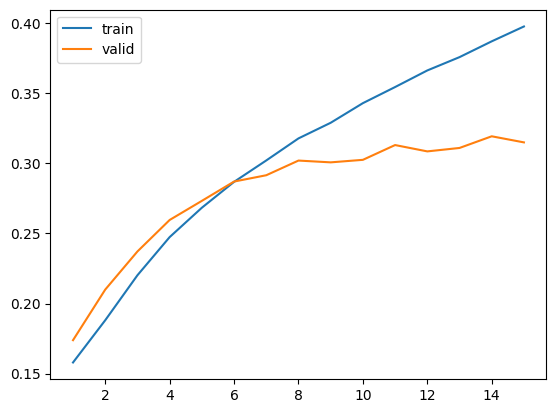

In [ ]:
epoch_count = range(1, len(history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia

In [ ]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def translate_sentence(input_text, 
                       model, 
                       input_tokenizer, 
                       word2idx_outputs, 
                       idx2word_target,
                       max_input_len,
                       max_output_len,
                       device):
    model.eval()
    # 1) Tokenizar y paddear
    seq = input_tokenizer.texts_to_sequences([input_text.lower()])[0]
    seq = pad_sequences([seq], maxlen=max_input_len, padding='post')
    encoder_input = torch.tensor(seq, dtype=torch.long).to(device)      # [1, max_input_len]
    # 2) Pasar por el encoder
    # prev_state = model.encoder(encoder_input)                           # (h, c)
    encoder_outputs, prev_state = model.encoder(encoder_input)
    # 3) Iniciar decoder con <sos>
    sos = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    decoder_input = torch.tensor([[sos]], dtype=torch.long).to(device)  # [1, 1]
    output_words = []
    # 4) Loop hasta max_output_len o hasta <eos>
    for _ in range(max_output_len):
        # logits, prev_state = model.decoder(decoder_input, prev_state)
        logits, prev_state = model.decoder(decoder_input, prev_state, encoder_outputs)
        # logits: [1, 1, vocab_size]
        logits = logits.squeeze(1)           # [1, vocab_size]
        topi = logits.argmax(dim=1)          # [1]
        idx = topi.item()                    # entero
        if idx == eos:
            break
        output_words.append(idx2word_target[idx])
        # re-alimentar al decoder
        decoder_input = topi.unsqueeze(1)    # [1, 1]
    return ' '.join(output_words)



In [ ]:
input_test = "My mother say hi."
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,  
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    My mother say hi.
Output:   


In [ ]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,   
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    Tom is sleeping, isn't he?
Output:   y la las fraseo


In [ ]:
import torch
import torch.nn.functional as F

def translate_beam_search(input_text,
                          model,
                          input_tokenizer,
                          word2idx_outputs,
                          idx2word_target,
                          max_input_len,
                          max_output_len,
                          device,
                          beam_width=3,
                          min_length=3):
    """
    Decoding con beam search para mejorar coherencia.
    """
    model.eval()
    # 1) Tokenizar y paddear
    seq = input_tokenizer.texts_to_sequences([input_text.lower()])[0]
    seq = pad_sequences([seq], maxlen=max_input_len, padding='post')
    encoder_input = torch.tensor(seq, dtype=torch.long).to(device)  # [1, T_src]
    # 2) Pasar por encoder
    encoder_outputs, prev_state = model.encoder(encoder_input)
    # 3) Preparar tokens especiales
    sos = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    
    # inicializar beam: lista de tuples (seq_ids, state, score)
    beams = [([sos], prev_state, 0.0)]
    
    for _ in range(max_output_len):
        all_candidates = []
        for seq_ids, state, score in beams:
            last_id = seq_ids[-1]
            if last_id == eos and len(seq_ids) > min_length:
                # si ya terminó y cumple longitud mínima, conservar
                all_candidates.append((seq_ids, state, score))
                continue
            input_tok = torch.tensor([[last_id]], device=device)
            logits, next_state = model.decoder(input_tok, state, encoder_outputs)
            log_probs = F.log_softmax(logits.squeeze(1), dim=1)[0]  # [vocab_size]
            top_probs, top_idxs = log_probs.topk(beam_width)
            for p, idx in zip(top_probs.tolist(), top_idxs.tolist()):
                new_seq = seq_ids + [idx]
                new_score = score + p
                all_candidates.append((new_seq, next_state, new_score))
        
        # seleccionar mejores beams
        beams = sorted(all_candidates, key=lambda x: x[2], reverse=True)[:beam_width]
        # si todas terminaron con <eos>, salir
        if all((seq_ids[-1] == eos and len(seq_ids) > min_length) for seq_ids, _, _ in beams):
            break

    # mejor hipótesis
    best_seq = beams[0][0]
    # convertir a words, ignorando SOS y EOS
    words = [idx2word_target[id] for id in best_seq if id not in {sos, eos}]
    return ' '.join(words)


# Ejemplo de uso:
# translation = translate_beam_search(
#     "Tom is sleeping, isn't he?",
#     seq2seq, input_tokenizer, word2idx_outputs, idx2word_target,
#     max_input_len, max_output_len, device, beam_width=5
# )
# print("Beam:", translation)


In [ ]:
translation = translate_beam_search(
    "Tom is sleeping, isn't he?",
    seq2seq, input_tokenizer, word2idx_outputs, idx2word_target,
    max_input_len, max_out_len, device, beam_width=5
)
print("Beam:", translation)


Beam: y la las fraseo


### 6 - Conclusión

Se trabajó sobre el ejemplo de encoder-decoder para traducción portado de keras a pytorch con el fin de optimixar el uso de GPU para el setup. \
Se incrementó la red y se le agregaron componentes como normalización, dropout y atención con el propósito de mejorar el modelo. Se utilizó como refenrencia https://towardsdatascience.com/a-comprehensive-guide-to-neural-machine-translation-using-seq2sequence-modelling-using-pytorch-41c9b84ba350/

Se omitió el uso de hot_one encoding para optimizar el consumo de memoria y asi poder usar todo el dataset.

Se utilizaron embeddings pre entrenados de FastText de 300 dims para el inglés y el español, con el fin de aumentar la capacidad de representación semántica. \
Para el caso del español se dejo un pequeño learning rate con el fin de alinear los espacios vectoriales haciendo fine tuning.

Lamentablemente no se logró mejoras respecto a lo implementado con keras, de esta forma podemos decir que el mejor camino es hacer un cambio de arquitectura a encoder-decoder usando Transformers.